# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

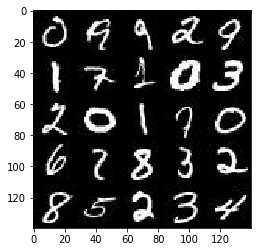

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

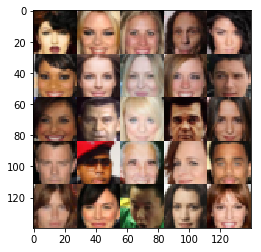

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels),name = "input_real")
    input_z = tf.placeholder(tf.float32,(None,z_dim),name = "input_z")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")

    return input_real, input_z, learning_rate 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
        # TODO: Implement Function
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse = reuse):
        # input size 28*28*3
        layer1 = tf.layers.conv2d(images, 64, 5, strides = 2,padding = 'same')
        relu1 = tf.maximum(0.12*layer1,layer1) # leaky relu

        # 14*14*64
        layer2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        layer2 = tf.nn.dropout(layer2, keep_prob=keep_prob)
        layer2 = tf.layers.batch_normalization(layer2, training = True)
        relu2 = tf.maximum(0.12*layer2,layer2)# leaky relu

        # 7*7*128
        layer3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        layer3 = tf.nn.dropout(layer3, keep_prob=keep_prob)
        layer3 = tf.layers.batch_normalization(layer3, training= True)
        relu3 = tf.maximum(0.12*layer3,layer3)

        flatten_layer = tf.reshape(relu3, (-1,4*4*256))
        flatten_layer = tf.layers.dropout(flatten_layer, rate=0.3)
        logits = tf.layers.dense(flatten_layer,1)
        
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        layer1 = tf.layers.dense(z,7*7*512);
        layer1 = tf.reshape(layer1,(-1,7,7,512))
        relu1 = tf.maximum(0.12*layer1,layer1)
        relu1 = tf.nn.dropout(relu1,keep_prob=0.8)
        
        # input 7*7*512
        layer2 = tf.layers.conv2d_transpose(relu1,256,5,strides=1,padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training = is_train)
        relu2 = tf.maximum(0.12*layer2,layer2)
        # output 7*7*256
        relu2 = tf.nn.dropout(relu2,keep_prob=0.8)
        
        layer3 = tf.layers.conv2d_transpose(relu2,128,5,strides=2,padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training = is_train)
        relu3  = tf.maximum(0.12*layer3,layer3)
        # 14*14*128
        
        logits = tf.layers.conv2d_transpose(relu3,out_channel_dim,5,strides=2,padding='same')
        output = tf.tanh(logits)
        
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = 2*batch_images
                step+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_optimizer, feed_dict = {input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_optimizer, feed_dict = {input_real:batch_images, input_z: batch_z, lr:learning_rate})
                
                if step%10==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}".format(epoch_i),
                          "The No. {} steps loss_d is {}".format(step,train_loss_d),
                          "The No. {} steps loss_g is {}".format(step,train_loss_g))
                    
                if step%100==0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0 The No. 10 steps loss_d is 0.4615941345691681 The No. 10 steps loss_g is 11.760826110839844
Epoch 0 The No. 20 steps loss_d is 0.5013543963432312 The No. 20 steps loss_g is 2.7930541038513184
Epoch 0 The No. 30 steps loss_d is 1.3728909492492676 The No. 30 steps loss_g is 4.46183967590332
Epoch 0 The No. 40 steps loss_d is 0.6037138104438782 The No. 40 steps loss_g is 2.4349286556243896
Epoch 0 The No. 50 steps loss_d is 0.8776224255561829 The No. 50 steps loss_g is 1.397990345954895
Epoch 0 The No. 60 steps loss_d is 0.9729202389717102 The No. 60 steps loss_g is 1.2237193584442139
Epoch 0 The No. 70 steps loss_d is 0.8799730539321899 The No. 70 steps loss_g is 1.8482434749603271
Epoch 0 The No. 80 steps loss_d is 1.1567583084106445 The No. 80 steps loss_g is 1.9302904605865479
Epoch 0 The No. 90 steps loss_d is 1.3661822080612183 The No. 90 steps loss_g is 0.7947903871536255
Epoch 0 The No. 100 steps loss_d is 1.3941264152526855 The No. 100 steps loss_g is 1.9564242362976074


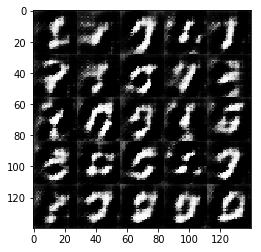

Epoch 0 The No. 110 steps loss_d is 1.343609094619751 The No. 110 steps loss_g is 0.5717759728431702
Epoch 0 The No. 120 steps loss_d is 1.1124646663665771 The No. 120 steps loss_g is 1.6845426559448242
Epoch 0 The No. 130 steps loss_d is 1.130741834640503 The No. 130 steps loss_g is 2.0087482929229736
Epoch 0 The No. 140 steps loss_d is 1.5616519451141357 The No. 140 steps loss_g is 1.9437127113342285
Epoch 0 The No. 150 steps loss_d is 1.389878749847412 The No. 150 steps loss_g is 1.4226572513580322
Epoch 0 The No. 160 steps loss_d is 1.6517739295959473 The No. 160 steps loss_g is 2.885120391845703
Epoch 0 The No. 170 steps loss_d is 1.716733694076538 The No. 170 steps loss_g is 0.4743601679801941
Epoch 0 The No. 180 steps loss_d is 1.1302125453948975 The No. 180 steps loss_g is 1.1172622442245483
Epoch 0 The No. 190 steps loss_d is 1.0609006881713867 The No. 190 steps loss_g is 1.2330267429351807
Epoch 0 The No. 200 steps loss_d is 1.1429272890090942 The No. 200 steps loss_g is 1.34

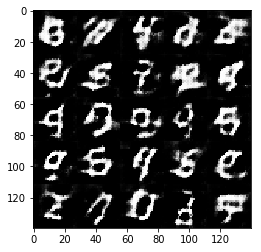

Epoch 0 The No. 210 steps loss_d is 1.2732799053192139 The No. 210 steps loss_g is 1.5713781118392944
Epoch 0 The No. 220 steps loss_d is 1.2189679145812988 The No. 220 steps loss_g is 1.1327521800994873
Epoch 0 The No. 230 steps loss_d is 1.3273634910583496 The No. 230 steps loss_g is 0.8387020826339722
Epoch 0 The No. 240 steps loss_d is 1.0613629817962646 The No. 240 steps loss_g is 1.2357701063156128
Epoch 0 The No. 250 steps loss_d is 1.2914607524871826 The No. 250 steps loss_g is 0.9062898755073547
Epoch 0 The No. 260 steps loss_d is 1.6173052787780762 The No. 260 steps loss_g is 2.8114142417907715
Epoch 0 The No. 270 steps loss_d is 1.0856021642684937 The No. 270 steps loss_g is 1.0534253120422363
Epoch 0 The No. 280 steps loss_d is 1.7904727458953857 The No. 280 steps loss_g is 0.4268264174461365
Epoch 0 The No. 290 steps loss_d is 1.2442259788513184 The No. 290 steps loss_g is 1.4218418598175049
Epoch 0 The No. 300 steps loss_d is 1.2495851516723633 The No. 300 steps loss_g is

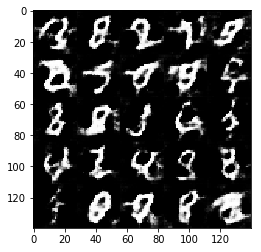

Epoch 0 The No. 310 steps loss_d is 1.3676002025604248 The No. 310 steps loss_g is 0.8005549311637878
Epoch 0 The No. 320 steps loss_d is 1.120290756225586 The No. 320 steps loss_g is 1.3111093044281006
Epoch 0 The No. 330 steps loss_d is 1.2227555513381958 The No. 330 steps loss_g is 1.478849172592163
Epoch 0 The No. 340 steps loss_d is 1.1795635223388672 The No. 340 steps loss_g is 0.8514899015426636
Epoch 0 The No. 350 steps loss_d is 1.1469142436981201 The No. 350 steps loss_g is 1.1970951557159424
Epoch 0 The No. 360 steps loss_d is 1.1271398067474365 The No. 360 steps loss_g is 0.8139210939407349
Epoch 0 The No. 370 steps loss_d is 1.1577975749969482 The No. 370 steps loss_g is 0.9225358963012695
Epoch 0 The No. 380 steps loss_d is 1.400591254234314 The No. 380 steps loss_g is 0.6702365875244141
Epoch 0 The No. 390 steps loss_d is 1.2221500873565674 The No. 390 steps loss_g is 0.7372474074363708
Epoch 0 The No. 400 steps loss_d is 1.3576769828796387 The No. 400 steps loss_g is 0.

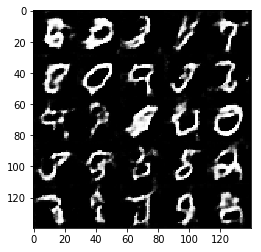

Epoch 0 The No. 410 steps loss_d is 1.4347903728485107 The No. 410 steps loss_g is 1.9176135063171387
Epoch 0 The No. 420 steps loss_d is 1.2100012302398682 The No. 420 steps loss_g is 0.9352425336837769
Epoch 0 The No. 430 steps loss_d is 1.053774118423462 The No. 430 steps loss_g is 1.290217399597168
Epoch 0 The No. 440 steps loss_d is 1.0671814680099487 The No. 440 steps loss_g is 1.4620338678359985
Epoch 0 The No. 450 steps loss_d is 1.0804954767227173 The No. 450 steps loss_g is 1.1796770095825195
Epoch 0 The No. 460 steps loss_d is 1.120380163192749 The No. 460 steps loss_g is 1.1000863313674927
Epoch 1 The No. 10 steps loss_d is 1.2843127250671387 The No. 10 steps loss_g is 1.4600516557693481
Epoch 1 The No. 20 steps loss_d is 1.0849939584732056 The No. 20 steps loss_g is 1.129237413406372
Epoch 1 The No. 30 steps loss_d is 1.2702000141143799 The No. 30 steps loss_g is 0.7789357900619507
Epoch 1 The No. 40 steps loss_d is 1.3446044921875 The No. 40 steps loss_g is 0.558972954750

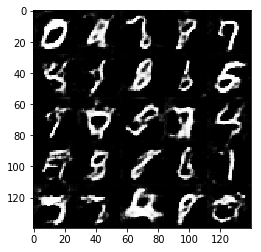

Epoch 1 The No. 110 steps loss_d is 1.1833335161209106 The No. 110 steps loss_g is 1.017720341682434
Epoch 1 The No. 120 steps loss_d is 1.1979188919067383 The No. 120 steps loss_g is 1.0323786735534668
Epoch 1 The No. 130 steps loss_d is 1.2479890584945679 The No. 130 steps loss_g is 0.8638039827346802
Epoch 1 The No. 140 steps loss_d is 1.095212697982788 The No. 140 steps loss_g is 0.925169825553894
Epoch 1 The No. 150 steps loss_d is 1.345639944076538 The No. 150 steps loss_g is 0.6223558187484741
Epoch 1 The No. 160 steps loss_d is 1.1692471504211426 The No. 160 steps loss_g is 1.4675171375274658
Epoch 1 The No. 170 steps loss_d is 1.0628280639648438 The No. 170 steps loss_g is 1.414504885673523
Epoch 1 The No. 180 steps loss_d is 1.2882637977600098 The No. 180 steps loss_g is 0.6767865419387817
Epoch 1 The No. 190 steps loss_d is 1.0258419513702393 The No. 190 steps loss_g is 1.1941077709197998
Epoch 1 The No. 200 steps loss_d is 1.1059398651123047 The No. 200 steps loss_g is 1.14

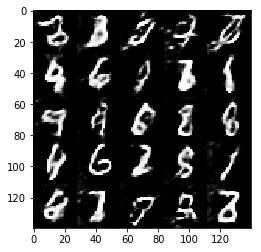

Epoch 1 The No. 210 steps loss_d is 1.0881366729736328 The No. 210 steps loss_g is 1.0867964029312134
Epoch 1 The No. 220 steps loss_d is 1.3018301725387573 The No. 220 steps loss_g is 0.6108263731002808
Epoch 1 The No. 230 steps loss_d is 1.1585495471954346 The No. 230 steps loss_g is 1.4193470478057861
Epoch 1 The No. 240 steps loss_d is 1.079038143157959 The No. 240 steps loss_g is 1.1940265893936157
Epoch 1 The No. 250 steps loss_d is 1.1886370182037354 The No. 250 steps loss_g is 0.9738583564758301
Epoch 1 The No. 260 steps loss_d is 1.1858735084533691 The No. 260 steps loss_g is 1.495845079421997
Epoch 1 The No. 270 steps loss_d is 1.1501061916351318 The No. 270 steps loss_g is 1.1590285301208496
Epoch 1 The No. 280 steps loss_d is 1.3139894008636475 The No. 280 steps loss_g is 1.636122465133667
Epoch 1 The No. 290 steps loss_d is 1.1116421222686768 The No. 290 steps loss_g is 1.6185925006866455
Epoch 1 The No. 300 steps loss_d is 1.1309583187103271 The No. 300 steps loss_g is 1.

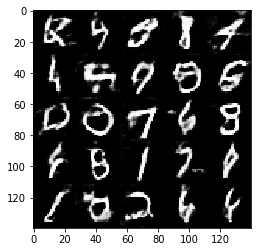

Epoch 1 The No. 310 steps loss_d is 1.065623164176941 The No. 310 steps loss_g is 1.1912699937820435
Epoch 1 The No. 320 steps loss_d is 0.9970933198928833 The No. 320 steps loss_g is 1.4361097812652588
Epoch 1 The No. 330 steps loss_d is 1.1982672214508057 The No. 330 steps loss_g is 0.8236768841743469
Epoch 1 The No. 340 steps loss_d is 1.1812610626220703 The No. 340 steps loss_g is 1.2276228666305542
Epoch 1 The No. 350 steps loss_d is 1.0521894693374634 The No. 350 steps loss_g is 1.254822015762329
Epoch 1 The No. 360 steps loss_d is 1.1815797090530396 The No. 360 steps loss_g is 1.1661243438720703
Epoch 1 The No. 370 steps loss_d is 1.269490122795105 The No. 370 steps loss_g is 1.8673300743103027
Epoch 1 The No. 380 steps loss_d is 1.1415657997131348 The No. 380 steps loss_g is 1.237243890762329
Epoch 1 The No. 390 steps loss_d is 1.3270108699798584 The No. 390 steps loss_g is 0.6152438521385193
Epoch 1 The No. 400 steps loss_d is 1.1394165754318237 The No. 400 steps loss_g is 1.0

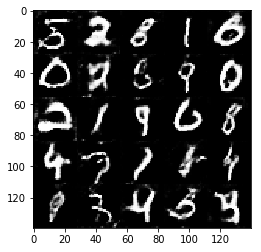

Epoch 1 The No. 410 steps loss_d is 1.0858796834945679 The No. 410 steps loss_g is 1.136700987815857
Epoch 1 The No. 420 steps loss_d is 1.2069066762924194 The No. 420 steps loss_g is 0.7227777242660522
Epoch 1 The No. 430 steps loss_d is 1.0994054079055786 The No. 430 steps loss_g is 1.3683613538742065
Epoch 1 The No. 440 steps loss_d is 1.0997288227081299 The No. 440 steps loss_g is 0.8924951553344727
Epoch 1 The No. 450 steps loss_d is 1.4479093551635742 The No. 450 steps loss_g is 0.5483795404434204
Epoch 1 The No. 460 steps loss_d is 1.0445618629455566 The No. 460 steps loss_g is 1.2398159503936768


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0 The No. 10 steps loss_d is 0.815841019153595 The No. 10 steps loss_g is 1.5982942581176758
Epoch 0 The No. 20 steps loss_d is 0.6649779081344604 The No. 20 steps loss_g is 1.8171589374542236
Epoch 0 The No. 30 steps loss_d is 0.5793724656105042 The No. 30 steps loss_g is 2.1775126457214355
Epoch 0 The No. 40 steps loss_d is 0.5046385526657104 The No. 40 steps loss_g is 2.6735215187072754
Epoch 0 The No. 50 steps loss_d is 0.43694552779197693 The No. 50 steps loss_g is 2.9682390689849854
Epoch 0 The No. 60 steps loss_d is 0.4989079236984253 The No. 60 steps loss_g is 2.9573235511779785
Epoch 0 The No. 70 steps loss_d is 0.4585404396057129 The No. 70 steps loss_g is 3.77893328666687
Epoch 0 The No. 80 steps loss_d is 0.4648812413215637 The No. 80 steps loss_g is 3.299699068069458
Epoch 0 The No. 90 steps loss_d is 0.4294000267982483 The No. 90 steps loss_g is 3.560699939727783
Epoch 0 The No. 100 steps loss_d is 0.5058417916297913 The No. 100 steps loss_g is 2.6067843437194824


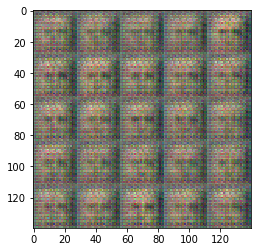

Epoch 0 The No. 110 steps loss_d is 0.7709548473358154 The No. 110 steps loss_g is 1.3862062692642212
Epoch 0 The No. 120 steps loss_d is 0.6836841702461243 The No. 120 steps loss_g is 1.9492378234863281
Epoch 0 The No. 130 steps loss_d is 0.6083014607429504 The No. 130 steps loss_g is 2.6375112533569336
Epoch 0 The No. 140 steps loss_d is 0.5172279477119446 The No. 140 steps loss_g is 3.9583792686462402
Epoch 0 The No. 150 steps loss_d is 0.46829351782798767 The No. 150 steps loss_g is 3.330225944519043
Epoch 0 The No. 160 steps loss_d is 0.45019596815109253 The No. 160 steps loss_g is 3.4949209690093994
Epoch 0 The No. 170 steps loss_d is 0.5863012671470642 The No. 170 steps loss_g is 2.5055298805236816
Epoch 0 The No. 180 steps loss_d is 0.5062991380691528 The No. 180 steps loss_g is 2.836392402648926
Epoch 0 The No. 190 steps loss_d is 0.5214910507202148 The No. 190 steps loss_g is 2.8361399173736572
Epoch 0 The No. 200 steps loss_d is 0.6464995741844177 The No. 200 steps loss_g is

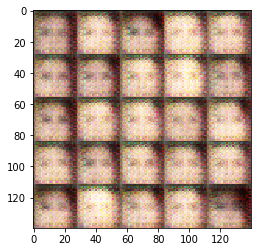

Epoch 0 The No. 210 steps loss_d is 0.7047113180160522 The No. 210 steps loss_g is 1.8324220180511475
Epoch 0 The No. 220 steps loss_d is 0.6521998047828674 The No. 220 steps loss_g is 2.583099842071533
Epoch 0 The No. 230 steps loss_d is 0.7428324222564697 The No. 230 steps loss_g is 1.7345324754714966
Epoch 0 The No. 240 steps loss_d is 0.5895771980285645 The No. 240 steps loss_g is 1.9569206237792969
Epoch 0 The No. 250 steps loss_d is 0.5465255975723267 The No. 250 steps loss_g is 2.2789700031280518
Epoch 0 The No. 260 steps loss_d is 0.787913978099823 The No. 260 steps loss_g is 1.469447135925293
Epoch 0 The No. 270 steps loss_d is 0.5220769643783569 The No. 270 steps loss_g is 2.569474935531616
Epoch 0 The No. 280 steps loss_d is 0.5603004693984985 The No. 280 steps loss_g is 2.165525436401367
Epoch 0 The No. 290 steps loss_d is 0.5558803081512451 The No. 290 steps loss_g is 2.465433120727539
Epoch 0 The No. 300 steps loss_d is 0.6132758259773254 The No. 300 steps loss_g is 1.980

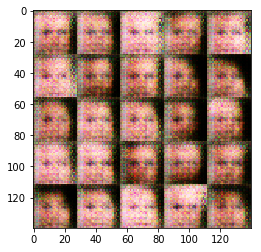

Epoch 0 The No. 310 steps loss_d is 0.5861620306968689 The No. 310 steps loss_g is 2.9266819953918457
Epoch 0 The No. 320 steps loss_d is 0.6577765941619873 The No. 320 steps loss_g is 2.2577638626098633
Epoch 0 The No. 330 steps loss_d is 0.5195173621177673 The No. 330 steps loss_g is 2.6953537464141846
Epoch 0 The No. 340 steps loss_d is 0.5792257785797119 The No. 340 steps loss_g is 2.5452051162719727
Epoch 0 The No. 350 steps loss_d is 0.7709529399871826 The No. 350 steps loss_g is 1.5960187911987305
Epoch 0 The No. 360 steps loss_d is 0.5972369313240051 The No. 360 steps loss_g is 2.723280191421509
Epoch 0 The No. 370 steps loss_d is 0.5952616930007935 The No. 370 steps loss_g is 1.8317739963531494
Epoch 0 The No. 380 steps loss_d is 0.5427303314208984 The No. 380 steps loss_g is 3.766880989074707
Epoch 0 The No. 390 steps loss_d is 0.5872268676757812 The No. 390 steps loss_g is 3.5571727752685547
Epoch 0 The No. 400 steps loss_d is 0.5397131443023682 The No. 400 steps loss_g is 2

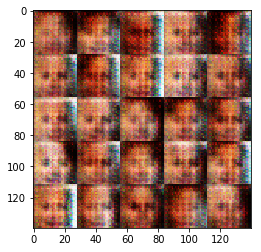

Epoch 0 The No. 410 steps loss_d is 0.6208045482635498 The No. 410 steps loss_g is 2.176140785217285
Epoch 0 The No. 420 steps loss_d is 0.5987030267715454 The No. 420 steps loss_g is 2.4979352951049805
Epoch 0 The No. 430 steps loss_d is 0.6240531206130981 The No. 430 steps loss_g is 2.7113866806030273
Epoch 0 The No. 440 steps loss_d is 0.6035686731338501 The No. 440 steps loss_g is 4.001044273376465
Epoch 0 The No. 450 steps loss_d is 0.5930123925209045 The No. 450 steps loss_g is 2.6407761573791504
Epoch 0 The No. 460 steps loss_d is 0.8409878015518188 The No. 460 steps loss_g is 3.2093100547790527
Epoch 0 The No. 470 steps loss_d is 0.7054100036621094 The No. 470 steps loss_g is 2.2599129676818848
Epoch 0 The No. 480 steps loss_d is 0.7386417388916016 The No. 480 steps loss_g is 1.797264575958252
Epoch 0 The No. 490 steps loss_d is 0.8018451929092407 The No. 490 steps loss_g is 1.8380310535430908
Epoch 0 The No. 500 steps loss_d is 0.7148950099945068 The No. 500 steps loss_g is 1.

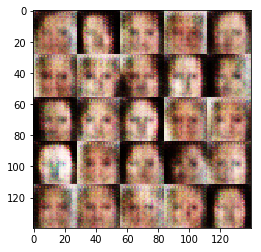

Epoch 0 The No. 510 steps loss_d is 0.7844973206520081 The No. 510 steps loss_g is 2.3555493354797363
Epoch 0 The No. 520 steps loss_d is 0.804139256477356 The No. 520 steps loss_g is 2.293895721435547
Epoch 0 The No. 530 steps loss_d is 0.9959792494773865 The No. 530 steps loss_g is 2.4977688789367676
Epoch 0 The No. 540 steps loss_d is 0.7143076658248901 The No. 540 steps loss_g is 2.2059993743896484
Epoch 0 The No. 550 steps loss_d is 0.8754507899284363 The No. 550 steps loss_g is 1.4775416851043701
Epoch 0 The No. 560 steps loss_d is 0.6121181845664978 The No. 560 steps loss_g is 2.7491931915283203
Epoch 0 The No. 570 steps loss_d is 0.7815675735473633 The No. 570 steps loss_g is 1.4678435325622559
Epoch 0 The No. 580 steps loss_d is 0.7727186679840088 The No. 580 steps loss_g is 1.7257537841796875
Epoch 0 The No. 590 steps loss_d is 0.9128364324569702 The No. 590 steps loss_g is 1.4034382104873657
Epoch 0 The No. 600 steps loss_d is 0.8273696899414062 The No. 600 steps loss_g is 2

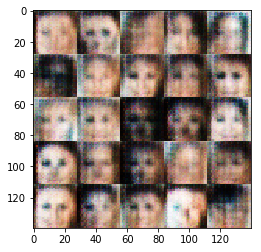

Epoch 0 The No. 610 steps loss_d is 0.7320221662521362 The No. 610 steps loss_g is 1.8756288290023804
Epoch 0 The No. 620 steps loss_d is 0.7187525033950806 The No. 620 steps loss_g is 1.7564334869384766
Epoch 0 The No. 630 steps loss_d is 0.8086299896240234 The No. 630 steps loss_g is 1.8761484622955322
Epoch 0 The No. 640 steps loss_d is 0.929741382598877 The No. 640 steps loss_g is 1.3009699583053589
Epoch 0 The No. 650 steps loss_d is 0.78013014793396 The No. 650 steps loss_g is 2.3522746562957764
Epoch 0 The No. 660 steps loss_d is 0.7432286739349365 The No. 660 steps loss_g is 1.9037652015686035
Epoch 0 The No. 670 steps loss_d is 0.8291219472885132 The No. 670 steps loss_g is 1.234994649887085
Epoch 0 The No. 680 steps loss_d is 0.7270012497901917 The No. 680 steps loss_g is 1.5972747802734375
Epoch 0 The No. 690 steps loss_d is 0.6862161159515381 The No. 690 steps loss_g is 2.1205496788024902
Epoch 0 The No. 700 steps loss_d is 0.7648724913597107 The No. 700 steps loss_g is 2.0

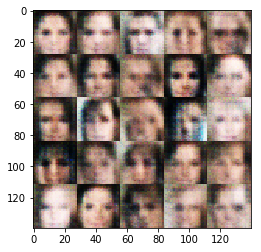

Epoch 0 The No. 710 steps loss_d is 0.7192152738571167 The No. 710 steps loss_g is 1.8553974628448486
Epoch 0 The No. 720 steps loss_d is 0.6943360567092896 The No. 720 steps loss_g is 2.2718911170959473
Epoch 0 The No. 730 steps loss_d is 0.826809287071228 The No. 730 steps loss_g is 1.6456482410430908
Epoch 0 The No. 740 steps loss_d is 0.6641300916671753 The No. 740 steps loss_g is 2.361680030822754
Epoch 0 The No. 750 steps loss_d is 0.9693945646286011 The No. 750 steps loss_g is 1.698270559310913
Epoch 0 The No. 760 steps loss_d is 0.6957915425300598 The No. 760 steps loss_g is 2.796821355819702
Epoch 0 The No. 770 steps loss_d is 0.7281438112258911 The No. 770 steps loss_g is 1.8778047561645508
Epoch 0 The No. 780 steps loss_d is 0.8877116441726685 The No. 780 steps loss_g is 2.041783571243286
Epoch 0 The No. 790 steps loss_d is 0.8286401033401489 The No. 790 steps loss_g is 1.527742862701416
Epoch 0 The No. 800 steps loss_d is 0.8851426243782043 The No. 800 steps loss_g is 2.256

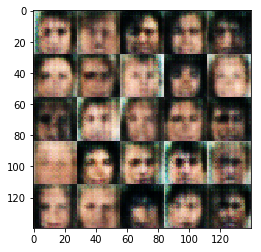

Epoch 0 The No. 810 steps loss_d is 0.7483255863189697 The No. 810 steps loss_g is 1.8274962902069092
Epoch 0 The No. 820 steps loss_d is 0.6931620836257935 The No. 820 steps loss_g is 1.9986557960510254
Epoch 0 The No. 830 steps loss_d is 0.9679932594299316 The No. 830 steps loss_g is 1.4202823638916016
Epoch 0 The No. 840 steps loss_d is 0.7728646993637085 The No. 840 steps loss_g is 1.6673393249511719
Epoch 0 The No. 850 steps loss_d is 0.782596230506897 The No. 850 steps loss_g is 2.004333019256592
Epoch 0 The No. 860 steps loss_d is 0.7673462629318237 The No. 860 steps loss_g is 2.1758008003234863
Epoch 0 The No. 870 steps loss_d is 0.8321129083633423 The No. 870 steps loss_g is 1.6256227493286133
Epoch 0 The No. 880 steps loss_d is 0.7509454488754272 The No. 880 steps loss_g is 2.2453367710113525
Epoch 0 The No. 890 steps loss_d is 0.8363792300224304 The No. 890 steps loss_g is 1.7413227558135986
Epoch 0 The No. 900 steps loss_d is 0.8901351690292358 The No. 900 steps loss_g is 1

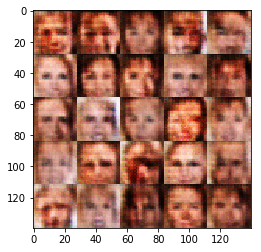

Epoch 0 The No. 910 steps loss_d is 0.8946465849876404 The No. 910 steps loss_g is 1.36632239818573
Epoch 0 The No. 920 steps loss_d is 0.9904556274414062 The No. 920 steps loss_g is 1.6407395601272583
Epoch 0 The No. 930 steps loss_d is 0.8670617938041687 The No. 930 steps loss_g is 2.186307907104492
Epoch 0 The No. 940 steps loss_d is 0.9209989905357361 The No. 940 steps loss_g is 1.5513567924499512
Epoch 0 The No. 950 steps loss_d is 1.079071283340454 The No. 950 steps loss_g is 1.2502648830413818
Epoch 0 The No. 960 steps loss_d is 0.9186514019966125 The No. 960 steps loss_g is 1.6077773571014404
Epoch 0 The No. 970 steps loss_d is 1.0255920886993408 The No. 970 steps loss_g is 1.5717558860778809
Epoch 0 The No. 980 steps loss_d is 0.8955377340316772 The No. 980 steps loss_g is 1.5659284591674805
Epoch 0 The No. 990 steps loss_d is 0.9082302451133728 The No. 990 steps loss_g is 2.087472438812256
Epoch 0 The No. 1000 steps loss_d is 0.8052628636360168 The No. 1000 steps loss_g is 2.

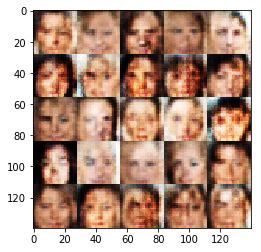

Epoch 0 The No. 1010 steps loss_d is 0.9312224984169006 The No. 1010 steps loss_g is 1.5456106662750244
Epoch 0 The No. 1020 steps loss_d is 0.8837660551071167 The No. 1020 steps loss_g is 1.4986355304718018
Epoch 0 The No. 1030 steps loss_d is 1.0227208137512207 The No. 1030 steps loss_g is 1.4650896787643433
Epoch 0 The No. 1040 steps loss_d is 0.6938151121139526 The No. 1040 steps loss_g is 1.7365117073059082
Epoch 0 The No. 1050 steps loss_d is 1.0423808097839355 The No. 1050 steps loss_g is 1.5095386505126953
Epoch 0 The No. 1060 steps loss_d is 1.1002280712127686 The No. 1060 steps loss_g is 1.7154791355133057
Epoch 0 The No. 1070 steps loss_d is 0.9909818768501282 The No. 1070 steps loss_g is 1.2000200748443604
Epoch 0 The No. 1080 steps loss_d is 1.0320789813995361 The No. 1080 steps loss_g is 1.6906650066375732
Epoch 0 The No. 1090 steps loss_d is 0.9328598976135254 The No. 1090 steps loss_g is 1.4899201393127441
Epoch 0 The No. 1100 steps loss_d is 0.7814381122589111 The No. 

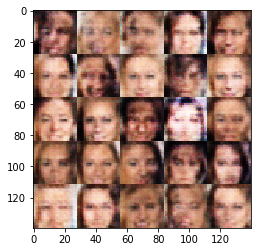

Epoch 0 The No. 1110 steps loss_d is 0.9835665822029114 The No. 1110 steps loss_g is 1.5967330932617188
Epoch 0 The No. 1120 steps loss_d is 0.9542428255081177 The No. 1120 steps loss_g is 1.552499532699585
Epoch 0 The No. 1130 steps loss_d is 0.9153022766113281 The No. 1130 steps loss_g is 1.7359189987182617
Epoch 0 The No. 1140 steps loss_d is 1.0696004629135132 The No. 1140 steps loss_g is 1.639791488647461
Epoch 0 The No. 1150 steps loss_d is 0.7601972818374634 The No. 1150 steps loss_g is 2.3961596488952637
Epoch 0 The No. 1160 steps loss_d is 0.8851751089096069 The No. 1160 steps loss_g is 1.5573877096176147
Epoch 0 The No. 1170 steps loss_d is 1.2569140195846558 The No. 1170 steps loss_g is 1.0251054763793945
Epoch 0 The No. 1180 steps loss_d is 1.0642106533050537 The No. 1180 steps loss_g is 1.6408120393753052
Epoch 0 The No. 1190 steps loss_d is 0.9801690578460693 The No. 1190 steps loss_g is 1.551396369934082
Epoch 0 The No. 1200 steps loss_d is 1.1828136444091797 The No. 120

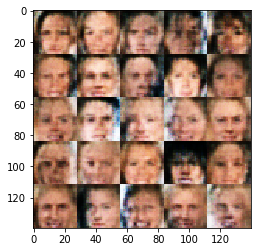

Epoch 0 The No. 1210 steps loss_d is 1.0518789291381836 The No. 1210 steps loss_g is 1.3354840278625488
Epoch 0 The No. 1220 steps loss_d is 1.0576436519622803 The No. 1220 steps loss_g is 1.1553694009780884
Epoch 0 The No. 1230 steps loss_d is 1.1647380590438843 The No. 1230 steps loss_g is 1.131544589996338
Epoch 0 The No. 1240 steps loss_d is 1.2553882598876953 The No. 1240 steps loss_g is 1.2279598712921143
Epoch 0 The No. 1250 steps loss_d is 0.9193370342254639 The No. 1250 steps loss_g is 1.732959508895874
Epoch 0 The No. 1260 steps loss_d is 1.1068034172058105 The No. 1260 steps loss_g is 1.3212138414382935
Epoch 0 The No. 1270 steps loss_d is 1.126167893409729 The No. 1270 steps loss_g is 1.1039961576461792
Epoch 0 The No. 1280 steps loss_d is 0.9388666749000549 The No. 1280 steps loss_g is 1.3614392280578613
Epoch 0 The No. 1290 steps loss_d is 1.013899564743042 The No. 1290 steps loss_g is 1.3800171613693237
Epoch 0 The No. 1300 steps loss_d is 1.0147910118103027 The No. 1300

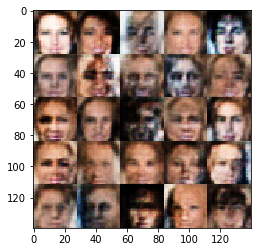

Epoch 0 The No. 1310 steps loss_d is 1.19166898727417 The No. 1310 steps loss_g is 1.043788194656372
Epoch 0 The No. 1320 steps loss_d is 0.9837318658828735 The No. 1320 steps loss_g is 1.3359602689743042
Epoch 0 The No. 1330 steps loss_d is 0.9501231908798218 The No. 1330 steps loss_g is 1.3037703037261963
Epoch 0 The No. 1340 steps loss_d is 1.039092779159546 The No. 1340 steps loss_g is 1.4303122758865356
Epoch 0 The No. 1350 steps loss_d is 1.0169672966003418 The No. 1350 steps loss_g is 1.477031946182251
Epoch 0 The No. 1360 steps loss_d is 0.9980143904685974 The No. 1360 steps loss_g is 1.5083221197128296
Epoch 0 The No. 1370 steps loss_d is 1.1485291719436646 The No. 1370 steps loss_g is 0.9821908473968506
Epoch 0 The No. 1380 steps loss_d is 1.0980968475341797 The No. 1380 steps loss_g is 1.284034013748169
Epoch 0 The No. 1390 steps loss_d is 0.8993486762046814 The No. 1390 steps loss_g is 1.4125165939331055
Epoch 0 The No. 1400 steps loss_d is 1.1654707193374634 The No. 1400 s

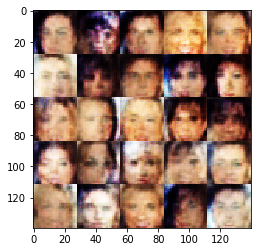

Epoch 0 The No. 1410 steps loss_d is 0.8803336024284363 The No. 1410 steps loss_g is 1.5737195014953613
Epoch 0 The No. 1420 steps loss_d is 1.0917601585388184 The No. 1420 steps loss_g is 1.2292249202728271
Epoch 0 The No. 1430 steps loss_d is 1.0958341360092163 The No. 1430 steps loss_g is 1.2287541627883911
Epoch 0 The No. 1440 steps loss_d is 0.8517247438430786 The No. 1440 steps loss_g is 1.800990104675293
Epoch 0 The No. 1450 steps loss_d is 1.0476757287979126 The No. 1450 steps loss_g is 1.5686414241790771
Epoch 0 The No. 1460 steps loss_d is 0.9837433099746704 The No. 1460 steps loss_g is 1.245915174484253
Epoch 0 The No. 1470 steps loss_d is 1.0314353704452515 The No. 1470 steps loss_g is 1.4724714756011963
Epoch 0 The No. 1480 steps loss_d is 1.0605823993682861 The No. 1480 steps loss_g is 1.4582808017730713
Epoch 0 The No. 1490 steps loss_d is 0.8182937502861023 The No. 1490 steps loss_g is 1.8175318241119385
Epoch 0 The No. 1500 steps loss_d is 1.236576795578003 The No. 150

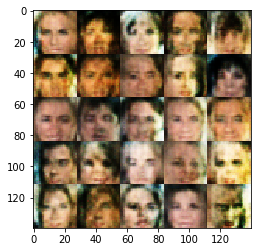

Epoch 0 The No. 1510 steps loss_d is 1.008120059967041 The No. 1510 steps loss_g is 1.5166535377502441
Epoch 0 The No. 1520 steps loss_d is 0.9103995561599731 The No. 1520 steps loss_g is 1.5161609649658203
Epoch 0 The No. 1530 steps loss_d is 1.0314252376556396 The No. 1530 steps loss_g is 1.4445610046386719
Epoch 0 The No. 1540 steps loss_d is 1.3149101734161377 The No. 1540 steps loss_g is 1.2017987966537476
Epoch 0 The No. 1550 steps loss_d is 1.0083880424499512 The No. 1550 steps loss_g is 1.1752841472625732
Epoch 0 The No. 1560 steps loss_d is 1.3953523635864258 The No. 1560 steps loss_g is 1.4839956760406494
Epoch 0 The No. 1570 steps loss_d is 0.9398776292800903 The No. 1570 steps loss_g is 1.4279141426086426
Epoch 0 The No. 1580 steps loss_d is 1.293245792388916 The No. 1580 steps loss_g is 0.8186372518539429
Epoch 0 The No. 1590 steps loss_d is 1.082373857498169 The No. 1590 steps loss_g is 1.3445619344711304
Epoch 0 The No. 1600 steps loss_d is 1.2289035320281982 The No. 160

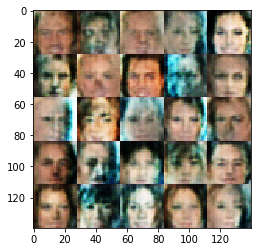

Epoch 0 The No. 1610 steps loss_d is 1.0319952964782715 The No. 1610 steps loss_g is 1.2526463270187378
Epoch 0 The No. 1620 steps loss_d is 1.0630253553390503 The No. 1620 steps loss_g is 1.343977928161621
Epoch 0 The No. 1630 steps loss_d is 1.052061676979065 The No. 1630 steps loss_g is 1.2609343528747559
Epoch 0 The No. 1640 steps loss_d is 1.1345869302749634 The No. 1640 steps loss_g is 1.2636332511901855
Epoch 0 The No. 1650 steps loss_d is 1.1429160833358765 The No. 1650 steps loss_g is 1.1363906860351562
Epoch 0 The No. 1660 steps loss_d is 1.0592212677001953 The No. 1660 steps loss_g is 1.2744536399841309
Epoch 0 The No. 1670 steps loss_d is 1.0034360885620117 The No. 1670 steps loss_g is 1.391054630279541
Epoch 0 The No. 1680 steps loss_d is 1.1615092754364014 The No. 1680 steps loss_g is 1.1311572790145874
Epoch 0 The No. 1690 steps loss_d is 1.0776104927062988 The No. 1690 steps loss_g is 1.3695329427719116
Epoch 0 The No. 1700 steps loss_d is 1.0762234926223755 The No. 170

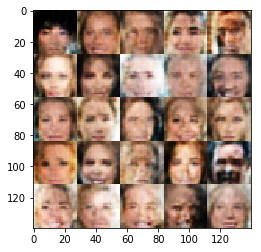

Epoch 0 The No. 1710 steps loss_d is 0.915283739566803 The No. 1710 steps loss_g is 1.4163639545440674
Epoch 0 The No. 1720 steps loss_d is 1.1131638288497925 The No. 1720 steps loss_g is 1.716841697692871
Epoch 0 The No. 1730 steps loss_d is 1.0949511528015137 The No. 1730 steps loss_g is 1.4677345752716064
Epoch 0 The No. 1740 steps loss_d is 1.201594352722168 The No. 1740 steps loss_g is 1.193271517753601
Epoch 0 The No. 1750 steps loss_d is 1.013769507408142 The No. 1750 steps loss_g is 1.509337306022644
Epoch 0 The No. 1760 steps loss_d is 0.925917387008667 The No. 1760 steps loss_g is 1.4731993675231934
Epoch 0 The No. 1770 steps loss_d is 1.069400668144226 The No. 1770 steps loss_g is 1.3648760318756104
Epoch 0 The No. 1780 steps loss_d is 1.0255279541015625 The No. 1780 steps loss_g is 1.6010797023773193
Epoch 0 The No. 1790 steps loss_d is 1.1375465393066406 The No. 1790 steps loss_g is 1.3406530618667603
Epoch 0 The No. 1800 steps loss_d is 1.0109745264053345 The No. 1800 ste

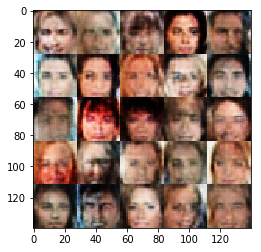

Epoch 0 The No. 1810 steps loss_d is 1.1087509393692017 The No. 1810 steps loss_g is 1.1088019609451294
Epoch 0 The No. 1820 steps loss_d is 1.0092025995254517 The No. 1820 steps loss_g is 1.5663294792175293
Epoch 0 The No. 1830 steps loss_d is 0.9910904765129089 The No. 1830 steps loss_g is 1.2994375228881836
Epoch 0 The No. 1840 steps loss_d is 1.0550111532211304 The No. 1840 steps loss_g is 1.8153759241104126
Epoch 0 The No. 1850 steps loss_d is 1.092470645904541 The No. 1850 steps loss_g is 0.8971235752105713
Epoch 0 The No. 1860 steps loss_d is 0.9915200471878052 The No. 1860 steps loss_g is 1.4433543682098389
Epoch 0 The No. 1870 steps loss_d is 1.0527417659759521 The No. 1870 steps loss_g is 1.2522279024124146
Epoch 0 The No. 1880 steps loss_d is 1.0668219327926636 The No. 1880 steps loss_g is 1.3492662906646729
Epoch 0 The No. 1890 steps loss_d is 1.0695010423660278 The No. 1890 steps loss_g is 1.3223350048065186
Epoch 0 The No. 1900 steps loss_d is 0.9073125123977661 The No. 1

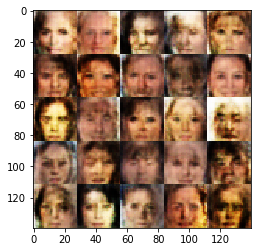

Epoch 0 The No. 1910 steps loss_d is 1.0272176265716553 The No. 1910 steps loss_g is 1.424317717552185
Epoch 0 The No. 1920 steps loss_d is 1.035097599029541 The No. 1920 steps loss_g is 1.3363521099090576
Epoch 0 The No. 1930 steps loss_d is 1.0556784868240356 The No. 1930 steps loss_g is 1.2965494394302368
Epoch 0 The No. 1940 steps loss_d is 0.9654591679573059 The No. 1940 steps loss_g is 1.296818733215332
Epoch 0 The No. 1950 steps loss_d is 1.0483639240264893 The No. 1950 steps loss_g is 1.1267187595367432
Epoch 0 The No. 1960 steps loss_d is 1.0390561819076538 The No. 1960 steps loss_g is 1.3282947540283203
Epoch 0 The No. 1970 steps loss_d is 1.0264294147491455 The No. 1970 steps loss_g is 1.3641738891601562
Epoch 0 The No. 1980 steps loss_d is 0.955053448677063 The No. 1980 steps loss_g is 1.7298173904418945
Epoch 0 The No. 1990 steps loss_d is 1.3993713855743408 The No. 1990 steps loss_g is 0.7558460235595703
Epoch 0 The No. 2000 steps loss_d is 1.0189769268035889 The No. 2000

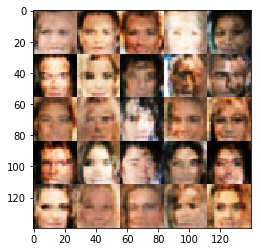

Epoch 0 The No. 2010 steps loss_d is 1.067641019821167 The No. 2010 steps loss_g is 1.3794798851013184
Epoch 0 The No. 2020 steps loss_d is 1.0763154029846191 The No. 2020 steps loss_g is 1.2427616119384766
Epoch 0 The No. 2030 steps loss_d is 1.117898941040039 The No. 2030 steps loss_g is 1.0264850854873657
Epoch 0 The No. 2040 steps loss_d is 1.0913209915161133 The No. 2040 steps loss_g is 1.167092204093933
Epoch 0 The No. 2050 steps loss_d is 0.9687095880508423 The No. 2050 steps loss_g is 1.1971865892410278
Epoch 0 The No. 2060 steps loss_d is 1.010965347290039 The No. 2060 steps loss_g is 1.162891149520874
Epoch 0 The No. 2070 steps loss_d is 1.0906665325164795 The No. 2070 steps loss_g is 1.1143332719802856
Epoch 0 The No. 2080 steps loss_d is 1.1035845279693604 The No. 2080 steps loss_g is 1.1814298629760742
Epoch 0 The No. 2090 steps loss_d is 0.9866237640380859 The No. 2090 steps loss_g is 1.4337494373321533
Epoch 0 The No. 2100 steps loss_d is 1.0293757915496826 The No. 2100 

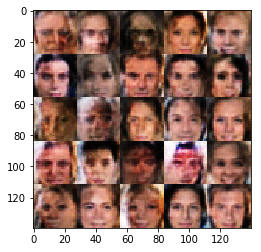

Epoch 0 The No. 2110 steps loss_d is 1.1827043294906616 The No. 2110 steps loss_g is 1.291057825088501
Epoch 0 The No. 2120 steps loss_d is 1.1314935684204102 The No. 2120 steps loss_g is 1.5055241584777832
Epoch 0 The No. 2130 steps loss_d is 1.0511767864227295 The No. 2130 steps loss_g is 1.1068826913833618
Epoch 0 The No. 2140 steps loss_d is 0.8844273686408997 The No. 2140 steps loss_g is 1.605985164642334
Epoch 0 The No. 2150 steps loss_d is 0.9797511100769043 The No. 2150 steps loss_g is 1.223466396331787
Epoch 0 The No. 2160 steps loss_d is 0.9069368243217468 The No. 2160 steps loss_g is 1.5949695110321045
Epoch 0 The No. 2170 steps loss_d is 1.0163966417312622 The No. 2170 steps loss_g is 1.4967501163482666
Epoch 0 The No. 2180 steps loss_d is 1.1738759279251099 The No. 2180 steps loss_g is 0.998654842376709
Epoch 0 The No. 2190 steps loss_d is 1.2894881963729858 The No. 2190 steps loss_g is 0.9040222764015198
Epoch 0 The No. 2200 steps loss_d is 1.0165741443634033 The No. 2200

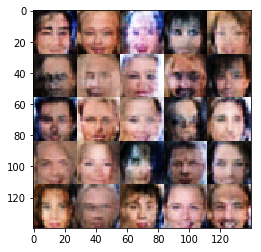

Epoch 0 The No. 2210 steps loss_d is 1.167494773864746 The No. 2210 steps loss_g is 1.0423941612243652
Epoch 0 The No. 2220 steps loss_d is 0.944058895111084 The No. 2220 steps loss_g is 1.2196142673492432
Epoch 0 The No. 2230 steps loss_d is 1.033854365348816 The No. 2230 steps loss_g is 1.3035268783569336
Epoch 0 The No. 2240 steps loss_d is 1.1850502490997314 The No. 2240 steps loss_g is 1.0168941020965576
Epoch 0 The No. 2250 steps loss_d is 0.9278019666671753 The No. 2250 steps loss_g is 1.3005716800689697
Epoch 0 The No. 2260 steps loss_d is 1.117048978805542 The No. 2260 steps loss_g is 1.127453327178955
Epoch 0 The No. 2270 steps loss_d is 1.1434290409088135 The No. 2270 steps loss_g is 1.293124794960022
Epoch 0 The No. 2280 steps loss_d is 1.2107244729995728 The No. 2280 steps loss_g is 0.9186023473739624
Epoch 0 The No. 2290 steps loss_d is 1.084998369216919 The No. 2290 steps loss_g is 1.0238146781921387
Epoch 0 The No. 2300 steps loss_d is 1.0851515531539917 The No. 2300 st

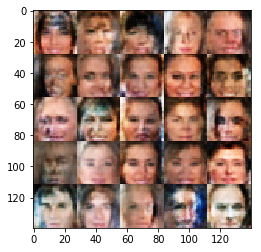

Epoch 0 The No. 2310 steps loss_d is 1.1028814315795898 The No. 2310 steps loss_g is 1.385589361190796
Epoch 0 The No. 2320 steps loss_d is 1.1055498123168945 The No. 2320 steps loss_g is 1.2163922786712646
Epoch 0 The No. 2330 steps loss_d is 0.9846047759056091 The No. 2330 steps loss_g is 1.4121122360229492
Epoch 0 The No. 2340 steps loss_d is 1.1330455541610718 The No. 2340 steps loss_g is 1.2708996534347534
Epoch 0 The No. 2350 steps loss_d is 0.9464686512947083 The No. 2350 steps loss_g is 1.379440426826477
Epoch 0 The No. 2360 steps loss_d is 1.1257603168487549 The No. 2360 steps loss_g is 0.8759621381759644
Epoch 0 The No. 2370 steps loss_d is 1.1544082164764404 The No. 2370 steps loss_g is 1.1636208295822144
Epoch 0 The No. 2380 steps loss_d is 1.0134984254837036 The No. 2380 steps loss_g is 1.2084717750549316
Epoch 0 The No. 2390 steps loss_d is 1.0938725471496582 The No. 2390 steps loss_g is 1.2873406410217285
Epoch 0 The No. 2400 steps loss_d is 1.2337231636047363 The No. 24

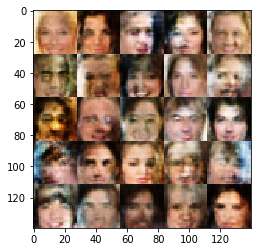

Epoch 0 The No. 2410 steps loss_d is 0.9442717432975769 The No. 2410 steps loss_g is 1.597306251525879
Epoch 0 The No. 2420 steps loss_d is 1.049283742904663 The No. 2420 steps loss_g is 1.661712884902954
Epoch 0 The No. 2430 steps loss_d is 0.9676600098609924 The No. 2430 steps loss_g is 1.1018178462982178
Epoch 0 The No. 2440 steps loss_d is 0.7910400629043579 The No. 2440 steps loss_g is 1.6688483953475952
Epoch 0 The No. 2450 steps loss_d is 1.0295127630233765 The No. 2450 steps loss_g is 1.2274649143218994
Epoch 0 The No. 2460 steps loss_d is 1.0167617797851562 The No. 2460 steps loss_g is 1.027385950088501
Epoch 0 The No. 2470 steps loss_d is 1.0900317430496216 The No. 2470 steps loss_g is 1.2391427755355835
Epoch 0 The No. 2480 steps loss_d is 0.9760394096374512 The No. 2480 steps loss_g is 1.355987310409546
Epoch 0 The No. 2490 steps loss_d is 1.067704200744629 The No. 2490 steps loss_g is 1.0848722457885742
Epoch 0 The No. 2500 steps loss_d is 1.0874974727630615 The No. 2500 s

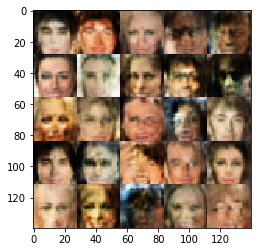

Epoch 0 The No. 2510 steps loss_d is 1.0397467613220215 The No. 2510 steps loss_g is 1.3383159637451172
Epoch 0 The No. 2520 steps loss_d is 0.9958767294883728 The No. 2520 steps loss_g is 1.3499996662139893
Epoch 0 The No. 2530 steps loss_d is 1.0892102718353271 The No. 2530 steps loss_g is 1.2438263893127441
Epoch 0 The No. 2540 steps loss_d is 1.0706042051315308 The No. 2540 steps loss_g is 1.1987102031707764
Epoch 0 The No. 2550 steps loss_d is 1.0014654397964478 The No. 2550 steps loss_g is 1.314575433731079
Epoch 0 The No. 2560 steps loss_d is 1.0890175104141235 The No. 2560 steps loss_g is 1.1290357112884521
Epoch 0 The No. 2570 steps loss_d is 0.9191454648971558 The No. 2570 steps loss_g is 1.5529255867004395
Epoch 0 The No. 2580 steps loss_d is 1.2659657001495361 The No. 2580 steps loss_g is 0.7138810753822327
Epoch 0 The No. 2590 steps loss_d is 1.1046500205993652 The No. 2590 steps loss_g is 1.134083867073059
Epoch 0 The No. 2600 steps loss_d is 0.8324341773986816 The No. 26

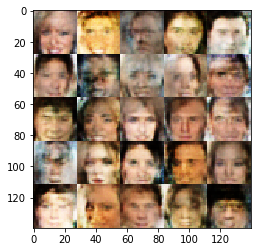

Epoch 0 The No. 2610 steps loss_d is 1.4961037635803223 The No. 2610 steps loss_g is 1.144374966621399
Epoch 0 The No. 2620 steps loss_d is 1.239988088607788 The No. 2620 steps loss_g is 1.2551990747451782
Epoch 0 The No. 2630 steps loss_d is 1.0974067449569702 The No. 2630 steps loss_g is 1.165484070777893
Epoch 0 The No. 2640 steps loss_d is 1.060738205909729 The No. 2640 steps loss_g is 0.9220468401908875
Epoch 0 The No. 2650 steps loss_d is 1.107477068901062 The No. 2650 steps loss_g is 0.9970678091049194
Epoch 0 The No. 2660 steps loss_d is 1.2185397148132324 The No. 2660 steps loss_g is 1.0382356643676758
Epoch 0 The No. 2670 steps loss_d is 1.026975154876709 The No. 2670 steps loss_g is 1.3695508241653442
Epoch 0 The No. 2680 steps loss_d is 1.1465259790420532 The No. 2680 steps loss_g is 1.1578655242919922
Epoch 0 The No. 2690 steps loss_d is 0.873653769493103 The No. 2690 steps loss_g is 1.442335844039917
Epoch 0 The No. 2700 steps loss_d is 1.2761709690093994 The No. 2700 ste

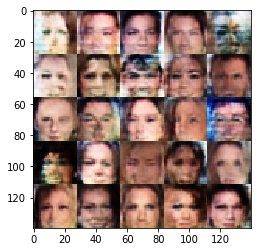

Epoch 0 The No. 2710 steps loss_d is 1.0811012983322144 The No. 2710 steps loss_g is 0.9737561941146851
Epoch 0 The No. 2720 steps loss_d is 1.018762469291687 The No. 2720 steps loss_g is 1.3191598653793335
Epoch 0 The No. 2730 steps loss_d is 1.107008934020996 The No. 2730 steps loss_g is 1.0690518617630005
Epoch 0 The No. 2740 steps loss_d is 1.0161004066467285 The No. 2740 steps loss_g is 1.4127020835876465
Epoch 0 The No. 2750 steps loss_d is 1.021851897239685 The No. 2750 steps loss_g is 1.2451574802398682
Epoch 0 The No. 2760 steps loss_d is 1.0708786249160767 The No. 2760 steps loss_g is 1.2882168292999268
Epoch 0 The No. 2770 steps loss_d is 1.1213011741638184 The No. 2770 steps loss_g is 1.4219822883605957
Epoch 0 The No. 2780 steps loss_d is 1.180843472480774 The No. 2780 steps loss_g is 0.8892273902893066
Epoch 0 The No. 2790 steps loss_d is 1.0232019424438477 The No. 2790 steps loss_g is 1.3784916400909424
Epoch 0 The No. 2800 steps loss_d is 1.0928915739059448 The No. 2800

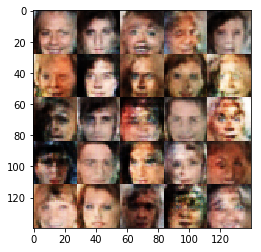

Epoch 0 The No. 2810 steps loss_d is 1.2270455360412598 The No. 2810 steps loss_g is 1.0284392833709717
Epoch 0 The No. 2820 steps loss_d is 1.0515053272247314 The No. 2820 steps loss_g is 1.1297968626022339
Epoch 0 The No. 2830 steps loss_d is 1.099583387374878 The No. 2830 steps loss_g is 1.1310583353042603
Epoch 0 The No. 2840 steps loss_d is 1.0062510967254639 The No. 2840 steps loss_g is 1.3273004293441772
Epoch 0 The No. 2850 steps loss_d is 0.9955376386642456 The No. 2850 steps loss_g is 1.3578462600708008
Epoch 0 The No. 2860 steps loss_d is 1.12131929397583 The No. 2860 steps loss_g is 1.2442691326141357
Epoch 0 The No. 2870 steps loss_d is 0.9964120388031006 The No. 2870 steps loss_g is 1.5760332345962524
Epoch 0 The No. 2880 steps loss_d is 0.9648804664611816 The No. 2880 steps loss_g is 1.2131778001785278
Epoch 0 The No. 2890 steps loss_d is 0.8887515664100647 The No. 2890 steps loss_g is 1.3535821437835693
Epoch 0 The No. 2900 steps loss_d is 1.180696725845337 The No. 2900

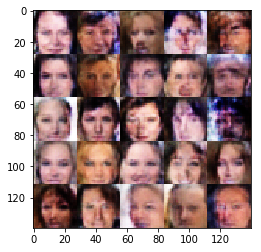

Epoch 0 The No. 2910 steps loss_d is 1.04734206199646 The No. 2910 steps loss_g is 1.2628376483917236
Epoch 0 The No. 2920 steps loss_d is 0.9793994426727295 The No. 2920 steps loss_g is 1.501796007156372
Epoch 0 The No. 2930 steps loss_d is 1.2024564743041992 The No. 2930 steps loss_g is 1.3936779499053955
Epoch 0 The No. 2940 steps loss_d is 1.1124708652496338 The No. 2940 steps loss_g is 1.0724791288375854
Epoch 0 The No. 2950 steps loss_d is 1.120389699935913 The No. 2950 steps loss_g is 1.0084707736968994
Epoch 0 The No. 2960 steps loss_d is 1.0940260887145996 The No. 2960 steps loss_g is 1.2503511905670166
Epoch 0 The No. 2970 steps loss_d is 0.95928955078125 The No. 2970 steps loss_g is 1.157651662826538
Epoch 0 The No. 2980 steps loss_d is 1.2167820930480957 The No. 2980 steps loss_g is 1.0571552515029907
Epoch 0 The No. 2990 steps loss_d is 1.0653858184814453 The No. 2990 steps loss_g is 1.13946533203125
Epoch 0 The No. 3000 steps loss_d is 1.2085740566253662 The No. 3000 step

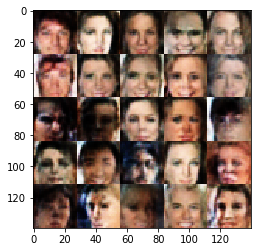

Epoch 0 The No. 3010 steps loss_d is 1.0034891366958618 The No. 3010 steps loss_g is 1.3716449737548828
Epoch 0 The No. 3020 steps loss_d is 0.9279055595397949 The No. 3020 steps loss_g is 1.662649393081665
Epoch 0 The No. 3030 steps loss_d is 0.9733244776725769 The No. 3030 steps loss_g is 1.3098009824752808
Epoch 0 The No. 3040 steps loss_d is 1.026310682296753 The No. 3040 steps loss_g is 1.4997262954711914
Epoch 0 The No. 3050 steps loss_d is 1.1156296730041504 The No. 3050 steps loss_g is 1.0432054996490479
Epoch 0 The No. 3060 steps loss_d is 1.1513705253601074 The No. 3060 steps loss_g is 1.1895091533660889
Epoch 0 The No. 3070 steps loss_d is 1.0551528930664062 The No. 3070 steps loss_g is 1.5560529232025146
Epoch 0 The No. 3080 steps loss_d is 1.14268159866333 The No. 3080 steps loss_g is 0.9209692478179932
Epoch 0 The No. 3090 steps loss_d is 1.0637485980987549 The No. 3090 steps loss_g is 1.1028085947036743
Epoch 0 The No. 3100 steps loss_d is 1.110424280166626 The No. 3100 

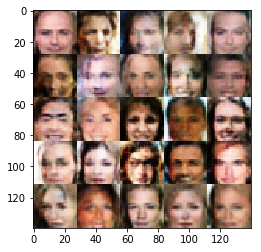

Epoch 0 The No. 3110 steps loss_d is 0.8719373941421509 The No. 3110 steps loss_g is 1.6502444744110107
Epoch 0 The No. 3120 steps loss_d is 0.9981248378753662 The No. 3120 steps loss_g is 1.3690710067749023
Epoch 0 The No. 3130 steps loss_d is 1.1640679836273193 The No. 3130 steps loss_g is 0.8864692449569702
Epoch 0 The No. 3140 steps loss_d is 1.0844262838363647 The No. 3140 steps loss_g is 1.3347456455230713
Epoch 0 The No. 3150 steps loss_d is 1.1372556686401367 The No. 3150 steps loss_g is 1.2803212404251099
Epoch 0 The No. 3160 steps loss_d is 1.0392205715179443 The No. 3160 steps loss_g is 1.2561949491500854


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.